[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Average number of nodes 13396
Average maximum depth 46


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished


Recall Baseline: 1.0 Test: 0.96 Train: 1.0
Precision Baseline: 0.81 Test: 0.88 Train: 1.0
Roc Baseline: 0.5 Test: 0.87 Train: 1.0


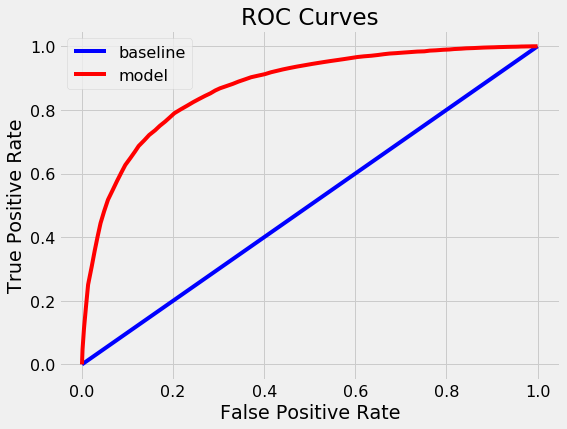

Confusion matrix, without normalization
[[ 2438  3136]
 [ 1043 23299]]


<Figure size 432x288 with 0 Axes>

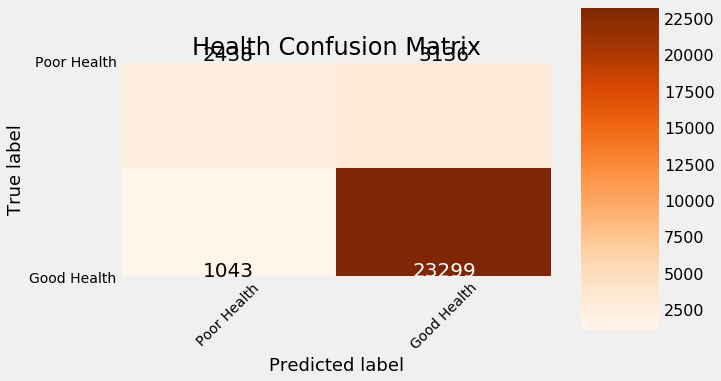

In [4]:
#import of relevant libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
#random state as global variable
RSEED = 50

# Load in data
df = pd.read_csv('https://s3.amazonaws.com/projects-rf/clean_data.csv')

# Full dataset: https://www.kaggle.com/cdc/behavioral-risk-factor-surveillance-system

# Extract the labels
labels = np.array(df.pop('label'))

# 30% examples in test data
# construct training and test dataset based on labels and df
train, test, train_labels, test_labels = train_test_split(df,
                                         labels, 
                                         stratify = labels,
                                         test_size = 0.3, 
                                         random_state = RSEED)

# Imputation of missing values
# fills missing values in train with the mean value of train
train = train.fillna(train.mean())
# fills missing values in test with the mean value of test
test = test.fillna(test.mean())

# Features for feature importances
features = list(train.columns)

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data using RandomForestClassifier
model.fit(train, train_labels)

# lists containing the number of nodes in the different trees and max_depths containing the number of stages
# in the decision trees
n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in model.estimators_:
    # the number of nodes are added to the respective list
    n_nodes.append(ind_tree.tree_.node_count)
    # the depth of the trees are added to the respective list
    max_depths.append(ind_tree.tree_.max_depth)
    #print avg. number of nodes of all trees
print(f'Average number of nodes {int(np.mean(n_nodes))}')
#prints avg. max_depths of all trees 
print(f'Average maximum depth {int(np.mean(max_depths))}')

# Training predictions (to demonstrate overfitting)
train_rf_predictions = model.predict(train)
# Class probabilites as a mean of the different trees, column 1 denotes the different rows
train_rf_probs = model.predict_proba(train)[:, 1]

# Testing predictions (to determine performance)
rf_predictions = model.predict(test)
#  Class probabilites for the different test
rf_probs = model.predict_proba(test)[:, 1]

#import additionally libraries for validitation of models
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
#import for plt
import matplotlib.pyplot as plt

# Plot formatting, firvethirtyeight is a specific stylesheet
plt.style.use('fivethirtyeight')
# fix font size in plot
plt.rcParams['font.size'] = 18

# function for evaluation of model
# imput predictions, probabilites, pedictions for train and train probabilities
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    # dictionary baseline contains stats for test data
    baseline = {}
    # recall in baseline dict based on test_labels compared with case 1
    baseline['recall'] = recall_score(test_labels, 
                                     [1 for _ in range(len(test_labels))])
    # precision in baseline based on test compared with case 1
    baseline['precision'] = precision_score(test_labels, 
                                      [1 for _ in range(len(test_labels))])
    # baseline roc fixed as 0.5, fully random
    baseline['roc'] = 0.5
    
    # result dicitonary analogue to baseline
    results = {}
    
    # as before but now compare tests with predictions
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    # train_results dictionary
    train_results = {}
    
    # compare train_labels with train predictions to test for overfitting i.e. if they are perfectly attuned
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    #prints different stats for the different cases
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates for baseline
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    # For the test
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)
    # figure adjustements, size and font size
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();
# evaluate model (previously defined function) on the predicitons prior to the functions and save plot as roc_auc_curve.png
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)
plt.savefig('roc_auc_curve.png')

#import confusion_matrix
from sklearn.metrics import confusion_matrix
#import itertools, package that contains iterator functions for efficient iterations
import itertools

# confusion_matrix plot function definition, with default color map and default title and by default without
# normalization and with input values cm (confusion matrix) and classes (the different classes)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    # if normalize normalize data in confusion matrix with repsect to data in confusion_matrix (sum of all entries)
    if normalize:
        # normalization
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    # print normalized or not normalized confusion matrix
    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    # plot with interpolation
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    # add colorbar
    plt.colorbar(aspect=4)
    # adjust ticks for number of classes
    tick_marks = np.arange(len(classes))
    # used classes for the tick marks
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    # float if normalized otherwise integer for formatting
    fmt = '.2f' if normalize else 'd'
    # use half max value of cm as threshold
    thresh = cm.max() / 2.
    
    # Labeling the plot
    # interate through all matrix elements
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    # plot grid    
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Confusion matrix
cm = confusion_matrix(test_labels, rf_predictions)
# Previosuly defined function with confusion matrix as calced before and two classes and overridden title
plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
                      title = 'Health Confusion Matrix')

plt.savefig('cm.png')

<img src="cm.png">

<img src="roc_auc_curve.png">

# problem in second figure and first one not optimal figure out later, but is corrected correctly before, problem with saving?